# Determining optimal thresholds for the tracker function
The floe tracking functionality uses a set of similarity metrics find the best matches between pairs of ice floes observed in different images. The first step is to filter the list of candidate floes by a time-dependent travel distance threshold. In this notebook, we examine the uncertainty in floe similarity metrics as a function of the floe shape and size, in order to determine the best choices of thresholds. Define the normalized absolute difference between X and Y as
$$ AD(X, Y) = \frac{2|X - Y|}{X + Y} $$
We can then define the following metrics for a pair of floes $f$ and $g$:

* $AD_{area} = AD(\mbox{area}(X), \mbox{area}(Y))$
* $AD_{convex} = AD(\mbox{convex\_area}(X), \mbox{convex\_area}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_minor\_length}(X), \mbox{axis\_minor\_length}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_major\_length}(X), \mbox{axis\_major\_length}(Y))$

For the ice floes with sufficient scores on the similarity metrics, additional measurements are taken based on the properties of the boundaries and the match score after optimal rotation. The QuadDIRECT (QD) algorithm is used to find the optimal rigid registration (shift + rotation) of a pair of images, optimized by minimizing the mean square error between the original image and the transformed image. For binary images, the error is equivalent to the recall (TBD: verify this! Could be a function of Re instead of actually Re). The (normalized) symmetric difference measures the area where the two objects don't match.

* $\psi\mbox{-}s$ curve correlation
* $Re(X, Y) = \frac{\mbox{area}(X \cap Y)}{\mbox{area}(X)}$
* $SD(X,Y) = \mbox{area}(X \setminus \, Y) \cup \mbox{area}(Y \setminus X)$
* Normalized $SD(X, Y) = SD(X, Y)/\mbox{area}(X)$

For $Re$ and $SD$, we take the measure between the source floe and the candidate match _after_ rotation. So letting $R_\theta$ be the rotation operator, and considering $X$ the source and $Y$ the candidate match, we compute the measures with $R_\theta Y$ instead of $Y$.

# Experiment
Even with optimal ice floe identification, measures of object properties from a discretzed, binary representation of an object will  have inherent uncertainty. To quantify the uncertainty, we use manually identified ice floe labels, and carry out an experiment in which we vary the object orientation and test the difference in each measure. 

* Rotation, original size. For each rotation $\theta$, we compute shape measures, the 4 ratios and the psi-s correlation, then we use the QD algorithm to estimate the rotation angle. We record $\hat \theta$ and the computed mismatch $mm$, and manually compute $Re(X, R_\hat{\theta} Y)$, and the normalized $SD(X, R_\hat{\theta})$.
* We also compute downsampled versions of each shape and rotated shape by scaling the shape to 1/2 size and 1/4 size. The scaling is done after the rotation, to simulate the effect of a true rotated shape being discretized by a low-resolution sensor, as opposed to adding error from rotating a discretized shape.

In [1]:
using Pkg;
Pkg.activate("calval")
# Pkg.precompile()
# Pkg.instantiate()

using IceFloeTracker
using IceFloeTracker: load, regionprops_table, label_components, imshow, absdiffmeanratio, mismatch
using DataFrames, Statistics, CSV, Dates, Plots, Interpolations, Images

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`
/Users/dwatkin2/.julia/conda/3/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2), incompatible header (2))


We're going to use some images in the test_images folder. Starting with one is fine. The aim is to have a function where we can
* import the image
* select the large-enough floes
* for each floe, compute the rotations
* for each floe and each rotation, compute the downsampled sizes
* compute the measures, ratios, and rotations
* save the results to a CSV for analysis

In [50]:
# Load the images from file
# fname = "001-baffin_bay-20220911-aqua-labeled_floes.png"
test_images_loc = "../data/test_images_tracker_setup/"
# image = load(joinpath(test_images_loc, fname))
        
# Add labels and get region properties
# labeled_image = label_components(image);
# props = regionprops_table(labeled_image);
props = []
labeled_images = []
for fname in ["001-baffin_bay-20220911-aqua-labeled_floes.png",
              "022-barents_kara_seas-20060909-aqua-labeled_floes.png",
              "043-beaufort_sea-20190813-aqua-labeled_floes.png",
              "065-bering_chukchi_seas-20080507-aqua-labeled_floes.png",
              "086-east_siberian_sea-20060927-aqua-labeled_floes.png",
              "107-greenland_sea-20210506-aqua-labeled_floes.png",
              "128-hudson_bay-20190415-aqua-labeled_floes.png",
              "148-laptev_sea-20110324-aqua-labeled_floes.png",
              "171-sea_of_okhostk-20090618-aqua-labeled_floes.png"]
    image = load(joinpath(test_images_loc, fname))
        
    # Add labels and get region properties
    labeled_image = label_components(image)
    push!(labeled_images, labeled_image)
    props_table = regionprops_table(labeled_image)
    IceFloeTracker.addfloemasks!(props_table, greaterthan0.(labeled_image))
    push!(props, props_table)        
    # append!(props, IceFloeTracker.addfloemasks!(props_table, greaterthan0.(labeled_image)))
end

In [59]:
 all_props = reduce(vcat, props)

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,mask
,Float64,Int64,Int64,Int64,Int64,Any,Any,Float64,Float64,Float64,Float64,Float64,Any
1,612.0,181,61,211,88,196,74,636.0,35.0553,22.3108,0.709409,94.669,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
2,4088.0,187,96,252,179,221,135,4272.0,89.9332,59.1066,1.1325,259.338,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
3,43.0,266,181,272,188,269,185,43.0,7.82671,7.01012,-1.51066,21.3137,Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 1 … 1 1; 0 0 … 1 0]
4,27.0,6,228,10,234,8,231,29.0,6.76274,5.08089,-1.44724,17.0711,Bool[0 0 … 0 0; 0 1 … 1 1; … ; 1 1 … 1 1; 0 1 … 1 0]
5,117.0,18,228,30,241,24,234,123.0,15.9855,9.46729,-0.856695,40.0416,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 1 1 … 0 0; 0 0 … 0 0]
6,201.0,259,230,273,248,266,239,210.0,20.1795,12.7236,-1.02764,52.8701,Bool[0 0 … 1 0; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0]
7,101.0,276,232,282,247,279,239,103.0,17.1598,7.56003,-1.52346,38.4853,Bool[0 1 … 1 0; 1 1 … 1 1; … ; 1 1 … 0 0; 0 0 … 0 0]
8,375.0,335,234,363,251,351,242,400.0,29.0614,17.0592,0.236758,78.2843,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 0 0]
9,92.0,320,252,335,258,328,255,96.0,16.2764,7.17898,-0.0610039,36.7279,Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 1 … 1 0; 0 0 … 0 0]


In [62]:
size(all_props)

(312, 13)

In [6]:
greaterthan0(x) = x .> 0 # convert labeled image to boolean
greaterthan05(x) = x .> 0.5 # used for the image resize step

IceFloeTracker.addfloemasks!(props, greaterthan0.(labeled_image));

In [8]:
IceFloeTracker.addψs!([props])

In [81]:
# compute_ratios((props_day1, r), (props_day2,s))
n = size(all_props)[1]
N = Int(round(1/2*n*(n-1)))
ad_area1 = zeros(N)
ad_maj1 =  zeros(N)
ad_min1 = zeros(N)
ad_con1 = zeros(N)
c = 1
for i in range(1, n)
    for j in range(1, i-1)
        area, majoraxis, minoraxis, convex_area = IceFloeTracker.compute_ratios((all_props, i), (all_props, j));
        ad_area1[c] = area
        ad_maj1[c] = majoraxis
        ad_min1[c] = minoraxis
        ad_con1[c] = convex_area
        c += 1
    end
end

In [86]:
N
sort(ad_area1)[1:1000:end]

49-element Vector{Float64}:
 0.0
 0.031413612565445025
 0.06369426751592357
 0.09665427509293681
 0.12987012987012986
 0.16560509554140126
 0.20224719101123595
 0.23529411764705882
 0.26666666666666666
 0.30057803468208094
 0.32967032967032966
 0.3614457831325301
 0.39593908629441626
 ⋮
 1.3147023086269745
 1.36
 1.4072345390898484
 1.4526315789473685
 1.5
 1.552
 1.6030075187969925
 1.6595744680851063
 1.714902807775378
 1.7731442869057548
 1.8388059701492536
 1.920704845814978

In [104]:
all_props[isequal.(all_props.area, 43), :]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,mask
,Float64,Int64,Int64,Int64,Int64,Any,Any,Float64,Float64,Float64,Float64,Float64,Any
1,43.0,266,181,272,188,269,185,43.0,7.82671,7.01012,-1.51066,21.3137,Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 1 … 1 1; 0 0 … 1 0]
2,43.0,283,267,290,273,286,270,45.0,8.45407,6.46936,-0.32327,21.8995,Bool[0 0 … 1 0; 0 1 … 1 1; … ; 0 1 … 1 0; 0 0 … 0 0]
3,43.0,44,323,49,331,47,327,45.0,9.02909,6.10195,1.43693,22.4853,Bool[0 0 … 0 0; 0 1 … 0 0; … ; 0 1 … 1 1; 0 1 … 1 0]
4,43.0,195,349,202,355,198,352,45.0,8.09021,6.85365,-0.390712,21.8995,Bool[0 1 … 0 0; 0 1 … 1 0; … ; 1 1 … 0 0; 0 1 … 0 0]
5,43.0,197,366,204,373,200,369,45.0,8.38969,6.63662,-0.730759,22.7279,Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 0 0; 0 0 … 0 0]


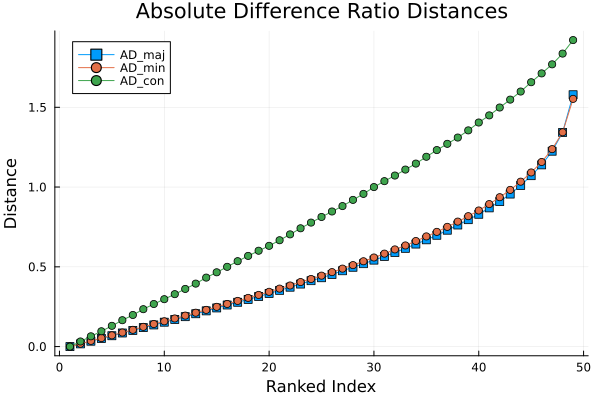

In [108]:
plot(sort(ad_area1)[1:1000:end], label="AD_area", m=:square)
plot(sort(ad_maj1)[1:1000:end], label="AD_maj", m=:square)
plot!(sort(ad_min1)[1:1000:end], label="AD_min", m=:circle)
plot!(sort(ad_con1)[1:1000:end], label="AD_con", m=:circle)
plot!(ylabel="Distance", xlabel="Ranked Index", title="Absolute Difference Ratio Distances")

In [69]:
import Pkg;
Pkg.add("Statistics")

   Resolving package versions...
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Project.toml`
  [10745b16] + Statistics v1.11.1
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Manifest.toml`
  [05823500] ↑ OpenLibm_jll v0.8.1+2 ⇒ v0.8.1+4
Precompiling project...
    641.1 ms  ✓ StringDistances
   1422.0 ms  ✓ TestImages
  2 dependencies successfully precompiled in 3 seconds. 371 already precompiled.


In [71]:
using Statistics

In [109]:
cor(ad_area1, ad_con1)

0.9983052725607984

In [110]:
cor(ad_area1, ad_maj1)

0.9164543240267928

In [111]:
cor(ad_maj1, ad_min1)

0.8361746161860159

In [112]:
cor(ad_min1, ad_con1)

0.9199806300539122

# Rotation experiment
This cell has been added to its own script `test_floe_shapes.jl`.

In [269]:
df = DataFrame(
               floe_id=Int16[],
               size=Float64[],
               rotation=Float64[],
               area=Float64[],
               convex_area=Float64[],
               major_axis_length=Float64[],
               minor_axis_length=Float64[],
               adr_area=Float64[],
               adr_convex_area=Float64[],
               adr_major_axis_length=Float64[],
               adr_minor_axis_length=Float64[],
               est_rotation=Float64[],
               mismatch=Float64[],
               recall=Float64[],
               normalized_sd=Float64[]
               )
floe_id = 0
for floe_data in eachrow(props) # replace this list with iterating through rows of props and checking area
    if floe_data["area"] > 500
        init_floe = copy(floe_data["mask"])
        # pad the floe to avoid changing floe area relative to image size
        n = Int64(round(maximum(size(init_floe))))
        padded_init = collect(padarray(init_floe, Fill(0, (n, n), (n, n))))
        for rotation in range(0, 90, 31)
            for scale in [1, 0.5, 0.25]
                if scale < 1        
                    new_size = trunc.(Int, size(imrotated) .* scale)
                    im_scaled = greaterthan05(collect(imresize(padded_init, new_size)))
                else
                    im_scaled = copy(padded_init)
            
                im_scaled_rotated = collect(imrotate(im_scaled, deg2rad(rotation), method=BSpline(Constant())));
                im_scaled_rotated = greaterthan05(im_scaled_rotated)
                        
                scaled_props = regionprops_table(label_components(im_scaled))
                scaled_rotated_props = regionprops_table(label_components(im_scaled_rotated))
                
                # rotation estimate
                mm, estimated_rotation = mismatch(im_scaled, im_scaled_rotated)
                
                # tbd: need to find shared indices first
                recall = 0
                normalized_sd = 0
                
                push!(df, (floe_id,
                           scale,
                           rotation,
                           scaled_rotated_props[1,:area],
                           scaled_rotated_props[1,:convex_area],
                           scaled_rotated_props[1,:major_axis_length],
                           scaled_rotated_props[1,:minor_axis_length],
                           absdiffmeanratio(scaled_props[1,:area], scaled_rotated_props[1,:area]),
                           absdiffmeanratio(scaled_props[1,:convex_area], scaled_rotated_props[1,:convex_area]),
                           absdiffmeanratio(scaled_props[1,:major_axis_length], scaled_rotated_props[1,:major_axis_length]),
                           absdiffmeanratio(scaled_props[1,:minor_axis_length], scaled_rotated_props[1,:minor_axis_length]),
                           estimated_rotation,
                           mm,
                           recall,
                           normalized_sd
                           )) 
                end
            end
        end
        floe_id += 1
    end
end
CSV.write("../data/shape_experiment1.csv", df);

In [268]:
typeof(padded_init)

OffsetMatrix{Bool, BitMatrix} (alias for OffsetArray{Bool, 2, BitArray{2}})

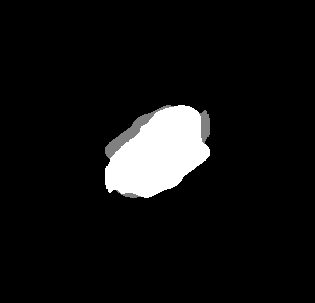

In [317]:
Gray.(im_scaled/2 + im_rotated)

In [329]:
a_not_b = (im_scaled .> 0) .& (greaterthan05(im_rotated) .== 0);
b_not_a = (im_scaled .== 0) .& (greaterthan05(im_rotated) .> 0);
sum(a_not_b .|| b_not_a)

1944

next steps:
- save results to CSV
- Examine statistics

- Error after best approximation rotation

In [278]:
fname = "021_flaskdjflkjasdf"
fname[1:3]

"021"

In [301]:
init_floe = copy(props[12, "mask"])
# pad the floe to avoid changing floe area relative to image size
n = Int64(round(maximum(size(init_floe))))
padded_init = collect(padarray(init_floe, Fill(0, (n, n), (n, n))))
example_images = []
for rotation in range(0, π, 6)
    new_size = trunc.(Int, size(padded_init) .* scale)
    im_rotated = imrotate(padded_init, rotation, axes(padded_init))
    im_rotated_scaled = greaterthan05(imresize(im_rotated, new_size))
    im_scaled = greaterthan05(imresize(padded_init, new_size))
    push!(example_images, im_rotated_scaled)
end

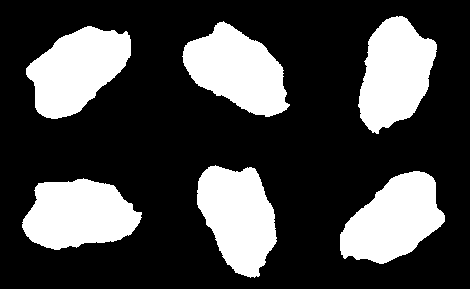

In [305]:
crop = 80
Images.mosaicview([Gray.(im[crop:end-crop, crop:end-crop]) for im in example_images], npad=1, nrow=2, fill=20)


In [275]:
sum(im_scaled .> 0), sum(im_rotated_scaled .> 0)

(503, 506)

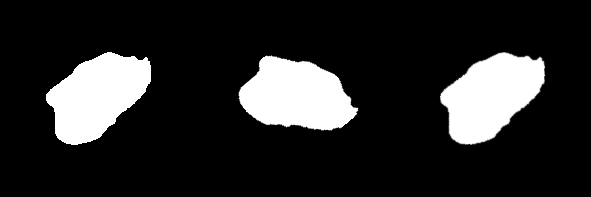

In [213]:
rotation = 50
imrotated = collect(imrotate(init_floe, deg2rad(rotation)));
mm, estimated_rotation = mismatch(init_floe, imrotated)
imrotated2 = collect(imrotate(imrotated, deg2rad(-estimated_rotation)));
Images.mosaicview([Gray.(init_floe), Gray.(imrotated), Gray.(imrotated2)], nrow=1)

In [187]:
mm, estimated_rotation = mismatch(im_scaled, im_scaled_rotated)
mm, estimated_rotation

(0.04796925126597019, 4.587694576707014)

In [208]:
size(init_floe), size(imrotated), size(imrotated2)

((93, 105), (141, 139), (197, 197))

In [165]:
sum(greaterthan05(imgw))

287

In [170]:
sum(greaterthan05(imrotate(props[12,:mask], 0)))

6219

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `IceFloeTracker.buildψs`


No documentation found for private symbol.

`IceFloeTracker.buildψs` is a `Function`.

```
# 1 method for generic function "buildψs" from IceFloeTracker:
 [1] buildψs(floe)
     @ ~/.julia/packages/IceFloeTracker/6ObKZ/src/tracker/tracker-funcs.jl:519
```
